# Wine Reviews Text Classification in Tensorflow
* Notebook by Adam Lang
* Date: 4/22/2024
* This notebook was inspired by the freecodecamp tutorial on neural network classification using Tensorflow. I will follow most of the same steps as they did with some additional insights.
* The purpose is to build a neural network text classifier in tensorflow on the wine reviews dataset.
* This will use pre-trained machine learning models from the **TensorFlow hub** that will be fine-tuned.
    * Model hub: https://www.tensorflow.org/hub
    * Embedding to us: `nnlm-en-dim50`
        * Token based text embedding trained on English Google News 7B corpus.

* At the bottom we will then try to implement an LSTM model.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# tensorflow
import tensorflow as tf
import tensorflow_hub as hub

### Wine Dataset upload

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/Text_Classification/wine-reviews.csv'

In [3]:
df = pd.read_csv(data_path, usecols=['country','description','points','price','variety','winery'])

In [4]:
## look at df
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


## EDA - exploratory data analysis

In [5]:
## df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [6]:
##check null values
df.isna().sum().sort_values()

description       0
points            0
winery            0
variety           1
country          63
price          8996
dtype: int64

It appears that price has the most NaN values at 8996 and country at 63.

In [7]:
## lets look closer
df[['price']].value_counts(dropna=False)

price
NaN      8996
20.0     6940
15.0     6066
25.0     5805
30.0     4951
         ... 
388.0       1
385.0       1
376.0       1
226.0       1
468.0       1
Name: count, Length: 391, dtype: int64

In [8]:
## lets look at some of the price metrics
df['price'].describe()

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

There are 120,975 price rows but we know that 8,996 of them are NaN.

### Drop NaN values

In [9]:
df = df.dropna(subset=['description','points'])

In [10]:
## lets look at df again
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


### Histogram plot

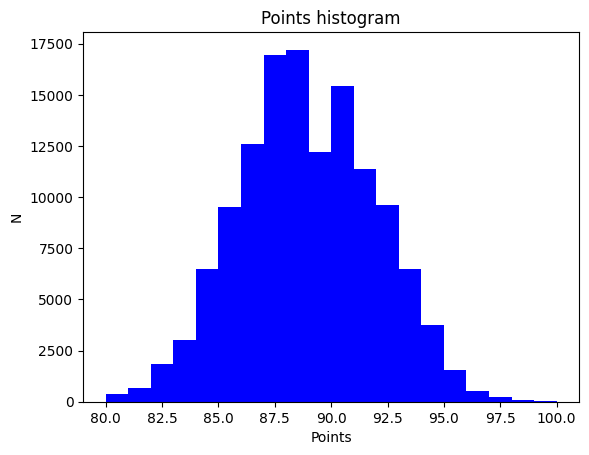

In [11]:
plt.hist(df.points, bins=20,color='blue')
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show();

Summary:
* The goal of this classification task is to classify the "points" into a low tier and high tier.

### Feature Engineering
* Create a boolean mask to filter df for wine points >= 90 and cast as integer.

In [12]:
df["label"] = (df.points >= 90).astype(int) #map to 0 or 1
df = df[["description","label"]]

In [13]:
## tail
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [15]:
## lets look at labels
df.label.value_counts()

label
0    80926
1    49045
Name: count, dtype: int64

Quick note: It is obvious the data is imbalanced here with twice as many 0 as there are 1's.

## Pre-processing and prepare for modeling
* Create train-test-val split
    * 80% train and rest for test-val

In [16]:
# draw random samples
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [17]:
## print samples for train, val test
print(f"Samples for train split: {len(train)}")
print(f"Samples for val split: {len(val)}")
print(f"Samples for test split: {len(test)}")

Samples for train split: 103976
Samples for val split: 12997
Samples for test split: 12998


## Tensorflow Function for input pipeline
* Using pre-built function from Tensorflow hub to `shuffle and batch` input data.
* Source: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [40]:
## create a utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset,
## then shuffles and batches the data.
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): ##change batch_size from 32 to larger -> dataset is larger
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"] # change this to just 'description' column {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))     #change from this ((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE) ##instead of batch_size use AUTOTUNE
  return ds

### Now use the "shuffle and batch" function above (`df_to_dataset`) on our data

In [65]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [66]:
## look at train_data
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'The extreme side of the grape variety comes out in this boisterous wine that smells like lemon and garlic, tastes like gooseberries and grapefruit, and has that vibrant, crisp texture that goes great with seafood.',
        b'With new wood dominating this still young wine, it is concentrated and full bodied, packed with firm tannins and dark fruit. There is a brooding character, the wood and tannins still right up front. Give this structured wine at least five years.',
        b'A longtime proponent of Rh\xc3\xb4ne blends, this producer combines 60% Grenache, 23% Mourv\xc3\xa8dre and 17% Syrah to full-bodied, ripely robust effect, all from estate-grown fruit. Smoky, charred oak and spicy acidity wrap around lush blackberry, cherry and tar, with plenty of grip to show on the finish.',
        ...,
        b'This is a structured wine, probably because of the Touriga Nacional in the blend. That also gives a perfumed edge to this r

We can see the tensor of strings and the corresponding labels.

## Embedding + Models from TF hub
* Note: Kaggle is now part of Tensorflow models so we will use the starter code from there as directed by TF hub:
* `import tensorflow_hub as hub`
* `embed = hub.load("https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1")`
* `embeddings = embed(["cat is on the mat", "dog is in the fog"])`


In [67]:
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1",
                           input_shape=[], dtype=tf.string)



## Build a model

In [154]:
model = tf.keras.Sequential()
model.add(hub_layer) #first transformation is text to number
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) # add dropout nodes
model.add(tf.keras.layers.Dense(16, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4)) # add dropout nodes
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

## Compile model
* The goal is binary classification thus we use `BinaryCrossEntropy()`

In [155]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## Evaluate

In [156]:
## eval train_data
model.evaluate(train_data)

102/102 [==============================] - 1s 9ms/step - loss: 0.6881 - accuracy: 0.5709


[0.688056230545044, 0.5709298253059387]

In [157]:
## eval validation data
model.evaluate(val_data)

13/13 [==============================] - 0s 9ms/step - loss: 0.6880 - accuracy: 0.5698


[0.6879929900169373, 0.5698238015174866]

In [158]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
102/102 [==============================] - 2s 11ms/step - loss: 0.6639 - accuracy: 0.6162 - val_loss: 0.6460 - val_accuracy: 0.6258
Epoch 2/10
102/102 [==============================] - 1s 11ms/step - loss: 0.6322 - accuracy: 0.6434 - val_loss: 0.6116 - val_accuracy: 0.6671
Epoch 3/10
102/102 [==============================] - 1s 11ms/step - loss: 0.6091 - accuracy: 0.6687 - val_loss: 0.5962 - val_accuracy: 0.6809
Epoch 4/10
102/102 [==============================] - 2s 16ms/step - loss: 0.5963 - accuracy: 0.6798 - val_loss: 0.5887 - val_accuracy: 0.6871
Epoch 5/10
102/102 [==============================] - 1s 11ms/step - loss: 0.5890 - accuracy: 0.6856 - val_loss: 0.5853 - val_accuracy: 0.6884
Epoch 6/10
102/102 [==============================] - 1s 11ms/step - loss: 0.5850 - accuracy: 0.6904 - val_loss: 0.5836 - val_accuracy: 0.6899
Epoch 7/10
102/102 [==============================] - 1s 11ms/step - loss: 0.5821 - accuracy: 0.6930 - val_loss: 0.5801 - val_accuracy: 0.6911

## Plot model history

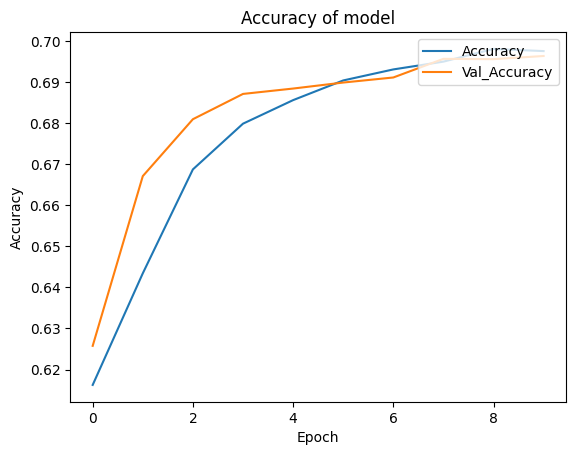

In [159]:
## plot accuracy
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy of model")
plt.legend(["Accuracy","Val_Accuracy"],loc="upper right")
plt.show();

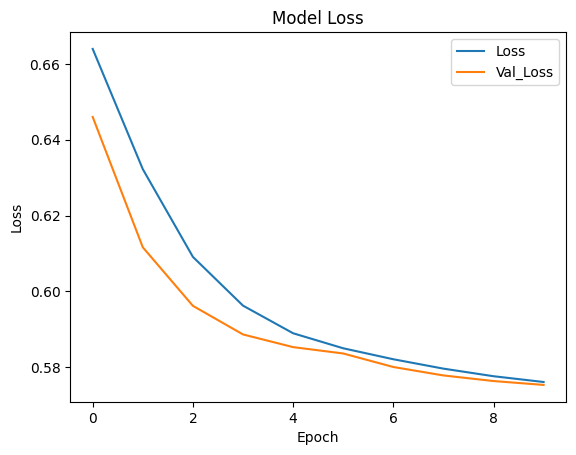

In [160]:
## plot loss
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Model Loss")
plt.legend(["Loss","Val_Loss"],loc="upper right")
plt.show();

Summary:
* We first trained the neural network classifier without any hyperparameter tuning. We then added 2 dropout layers and I removed the 2nd dropout layer to get the above result.
* We can see via the plots that the accuracy continues to decrease over the 10 epochs and may even converge and start leveling off at around 10 epochs. The loss was actually less for the validation set which means this model was better.
* For the accuracy, it does appear to get more accurate as the epochs go up and the validation set is slightly less accurate than the training set which again shows us a better model without any overfitting.

## Evaluate on test data

In [161]:
model.evaluate(test_data)

13/13 [==============================] - 0s 28ms/step - loss: 0.5632 - accuracy: 0.7081


[0.5631802678108215, 0.7081089615821838]

The accuracy on the test set was actually better than both the training and val sets and the loss was also less.

# LSTM custom model for text classification

In [162]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [163]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

We can see the first 20 from the vocabulary are seen above with the UNK tokens.

## Create LSTM model

In [164]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Compile LSTM model

In [165]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Evaluate on train data

In [167]:
model.evaluate(train_data)
model.evaluate(val_data)

13/13 [==============================] - 2s 133ms/step - loss: 0.6931 - accuracy: 0.6253


[0.6931475400924683, 0.6252981424331665]

### Train LSTM model

In [168]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 29s 240ms/step - loss: 0.6931 - accuracy: 0.6216 - val_loss: 0.6931 - val_accuracy: 0.6253
Epoch 2/5
102/102 [==============================] - 28s 277ms/step - loss: 0.6931 - accuracy: 0.6216 - val_loss: 0.6931 - val_accuracy: 0.6253
Epoch 3/5
102/102 [==============================] - 25s 244ms/step - loss: 0.6931 - accuracy: 0.6216 - val_loss: 0.6931 - val_accuracy: 0.6253
Epoch 4/5
102/102 [==============================] - 24s 239ms/step - loss: 0.6931 - accuracy: 0.6216 - val_loss: 0.6931 - val_accuracy: 0.6253
Epoch 5/5
102/102 [==============================] - 24s 230ms/step - loss: 0.6931 - accuracy: 0.6216 - val_loss: 0.6931 - val_accuracy: 0.6253


### Evaluate on test data

In [169]:
model.evaluate(test_data)

13/13 [==============================] - 1s 85ms/step - loss: 0.6931 - accuracy: 0.6283


[0.693147599697113, 0.6282504796981812]

Summary: The LSTM model was less accurate than the network we built above.